# From Image to Graph

## Analogy between image and graph data
We can think of a convolution of an image from the perspective of networks.
In the convolution of an image, a pixel is convolved with its *neighbors*. We can regard each pixel as a node, and each node is connected to its neighboring nodes (pixels) that are involved in the convolution.

![](https://av-eks-lekhak.s3.amazonaws.com/media/__sized__/article_images/conv_graph-thumbnail_webp-600x300.webp)

Building on this analogy, we can extend the idea of convolution to general graph data.
Each node has a pixel value(s) (e.g., feature vector), which is convolved with the values of its neighbors in the graph.
This is the key idea of graph convolutional networks.
But, there is a key difference: while the number of neighbors for an image is homogeneous, the number of neighbors for a node in a graph can be heterogeneous. Each pixel has the same number of neighbors (except for the boundary pixels), but nodes in a graph can have very different numbers of neighbors. This makes it non-trivial to define the "kernel" for graph convolution.

## Spectral filter on graphs
Just like we can define a convolution on images in the frequency domain, we can also define a ''frequency domain'' for graphs.

Consider a network of $N$ nodes, where each node has a feature variable ${\mathbf x}_i \in \mathbb{R}$. We are interested in:

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2,
$$

where $A_{ij}$ is the adjacency matrix of the graph. The quantity $J$ represents *the total variation* of $x$ between connected nodes; a small $J$ means that connected nodes have similar $x$ (low variation; low frequency), while a large $J$ means that connected nodes have very different $x$ (high variation; high frequency).

We can rewrite $J$ as

$$
J = \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 = {\bf x}^\top {\bf L} {\bf x},
$$

where ${\bf L}$ is the Laplacian matrix of the graph given by

$$
L_{ij} = \begin{cases}
-1 & \text{if } i \text{ and } j \text{ are connected} \\
k_i & \text{if } i = j \\
0 & \text{otherwise}
\end{cases}.
$$

and ${\bf x} = [x_1,x_2,\ldots, x_N]^\top$ is a column vector of feature variables.


```{admonition} Detailed derivation
:tag: note
:class: dropdown

The above derivation shows that the total variation of $x$ between connected nodes is proportional to ${\bf x}^\top {\bf L} {\bf x}$.

$$
\begin{aligned}
J &= \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N A_{ij}(x_i - x_j)^2 \\
&= \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \underbrace{A_{ij}\left( x_i^2 +x_j^2\right)}_{\text{symmetric}} - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \sum_{i=1}^Nx_i^2\underbrace{\sum_{j=1}^N A_{ij}}_{\text{degree of node } i, k_i} - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \sum_{i=1}^Nx_i^2 k_i - \sum_{i=1}^N\sum_{j=1}^N A_{ij}x_ix_j \\
&= \underbrace{[x_1,x_2,\ldots, x_N]}_{{\bf x}} \underbrace{\begin{bmatrix} k_1 & 0 & \cdots & 0 \\ 0 & k_2 & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & k_N \end{bmatrix}}_{{\bf D}} \underbrace{\begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_N \end{bmatrix}}_{{\bf x}} - 2\underbrace{\sum_{i=1}^N\sum_{j=1}^N A_{ij}}_{{\bf x}^\top {\mathbf A} {\bf x}} {\bf x} \\
&= {\bf x}^\top {\bf D} {\bf x} - {\bf x}^\top {\mathbf A} {\bf x} \\
&= {\bf x}^\top {\bf L} {\bf x},
\end{aligned}
$$
```

Let us showcase the analogy between the Fourier transform and the Laplacian matrix.
In the Fourier transform, a signal is decomposed into sinusoidal basis functions. Similarly, for a graph, we can decompose the variation $J$ into eigenvector bases.

$$
J = \sum_{i=1}^N \lambda_i  {\bf x}^\top {\mathbf u}_i {\mathbf u}_i^\top {\bf x} = \sum_{i=1}^N \lambda_i  ||{\bf x}^\top {\mathbf u}_i||^2.
$$

where ${\mathbf u}_i$ is the eigenvector corresponding to the eigenvalue $\lambda_i$.
- The term $({\bf x}^\top {\mathbf u}_i)$ is a dot-product between the feature vector ${\bf x}$ and the eigenvector ${\mathbf u}_i$, which measures how much ${\bf x}$ *coheres* with eigenvector ${\mathbf u}_i$, similar to how Fourier coefficients measure coherency with sinusoids.
- Each $||{\bf x}^\top {\mathbf u}_i||^2$ is the ''strength'' of ${\bf x}$ with respect to the eigenvector ${\mathbf u}_i$, and the total variation $J$ is a weighted sum of these strengths.

Some eigenvectors correspond to low-frequency components, while others correspond to high-frequency components. For example, the total variation $J$ for an eigenvector ${\mathbf u}_i$ is given by

$$
J = \frac{1}{2} \sum_{j}\sum_{\ell} A_{j\ell}(u_{ij} - u_{i\ell})^2 = {\mathbf u}_i^\top {\mathbf L} {\mathbf u}_i = \lambda_i.
$$

This equation provides key insight into the meaning of eigenvalues:

1. For an eigenvector ${\mathbf u}_i$, its eigenvalue $\lambda_i$ measures the total variation for ${\mathbf u}_i$.
2. Large eigenvalues mean large differences between neighbors (high frequency), while small eigenvalues mean small differences (low frequency).

Thus, if ${\bf x}$ aligns well with ${\mathbf u}_i$ with a large $\lambda_i$, then ${\bf x}$ has a strong high-frequency component; if ${\bf x}$ aligns well with ${\mathbf u}_i$ with a small $\lambda_i$, then ${\bf x}$ has strong low-frequency component.

### Spectral Filtering

Eigenvalues $\lambda_i$ can be thought of as a *filter* that controls which frequency components pass through. Instead of using the filter associated with the Laplacian matrix, we can design a filter $h(\lambda_i)$ to control which frequency components pass through. This leads to the idea of *spectral filtering*. Two common filters are:

1. **Low-pass Filter**:
   $$h_{\text{low}}(\lambda) = \frac{1}{1 + \alpha\lambda}$$
   - Preserves low frequencies (small λ)
   - Suppresses high frequencies (large λ)
   - Results in smoother signals

2. **High-pass Filter**:
   $$h_{\text{high}}(\lambda) = \frac{\alpha\lambda}{1 + \alpha\lambda}$$
   - Preserves high frequencies
   - Suppresses low frequencies
   - Emphasizes differences between neighbors

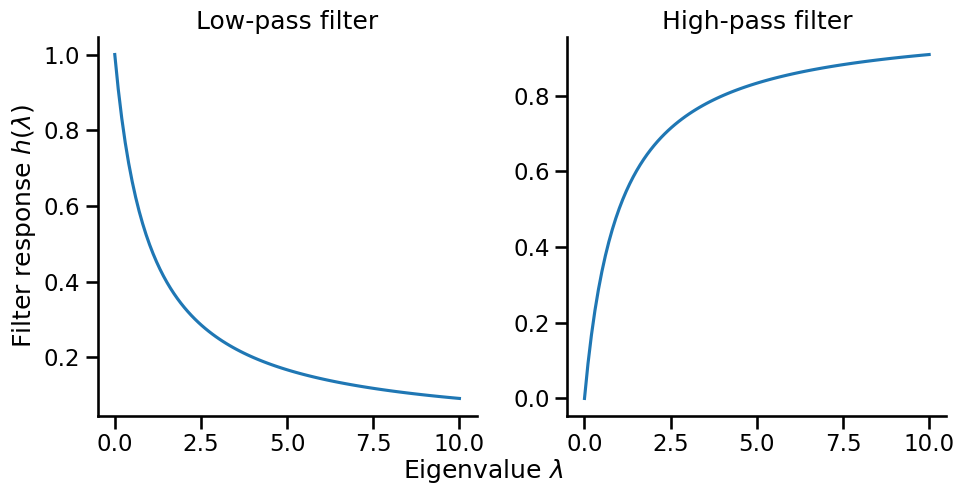

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

alpha = 1
lambdas = np.linspace(0, 10, 100)
h_low = 1 / (1 + alpha * lambdas)
h_high = (alpha * lambdas) / (1 + alpha * lambdas)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=lambdas, y=h_low, label="Low-pass filter", ax=axes[0])
axes[0].legend(frameon=False).remove()
sns.lineplot(x=lambdas, y=h_high, label="High-pass filter", ax=axes[1])
axes[1].legend(frameon=False).remove()
axes[0].set_title("Low-pass filter")
axes[1].set_title("High-pass filter")
fig.text(0.5, 0.01, "Eigenvalue $\lambda$", ha="center")
axes[0].set_ylabel("Filter response $h(\lambda)$")
sns.despine()
plt.tight_layout()

### Example

Let us showcase the idea of spectral filtering with a simple example with the karate club network.

In [2]:
import igraph as ig
import numpy as np
from scipy import sparse
import matplotlib as mpl

G = ig.Graph.Famous("Zachary")
A = G.get_adjacency_sparse()

We will first compute the laplacian matrix and its eigendecomposition.

In [3]:
# Compute Laplacian matrix
deg = np.array(A.sum(axis=1)).reshape(-1)
D = sparse.diags(deg)
L = D - A

# Compute eigendecomposition
evals, evecs = np.linalg.eigh(L.toarray())

# Sort eigenvalues and eigenvectors
order = np.argsort(evals)
evals = evals[order]
evecs = evecs[:, order]

Now, let's create a low-pass and high-pass filter.

In [4]:
alpha = 2
L_low = evecs @ np.diag(1 / (1 + alpha * evals)) @ evecs.T
L_high = evecs @ np.diag(alpha * evals / (1 + alpha * evals)) @ evecs.T

print("Size of low-pass filter:", L_low.shape)
print("Size of high-pass filter:", L_high.shape)

Size of low-pass filter: (34, 34)
Size of high-pass filter: (34, 34)


Notice that the high-pass filter and low-pass filter are matrices of the same size as the adjacency matrix $A$, which defines a 'convolution' on the graph as follows:

$$
{\bf x}' = {\bf L}_{\text{low}} {\bf x} \quad \text{or} \quad {\bf x}' = {\bf L}_{\text{high}} {\bf x}.
$$

where ${\bf L}_{\text{low}}$ and ${\bf L}_{\text{high}}$ are the low-pass and high-pass filters, respectively, and ${\bf x}'$ is the convolved feature vector.

Now, let's see how these filters work. Our first example is a random feature vector.

In [5]:
# Random feature vector
x = np.random.randn(A.shape[0], 1)

# Convolve with low-pass filter
x_low = L_low @ x

# Convolve with high-pass filter
x_high = L_high @ x

Let us visualize the results.

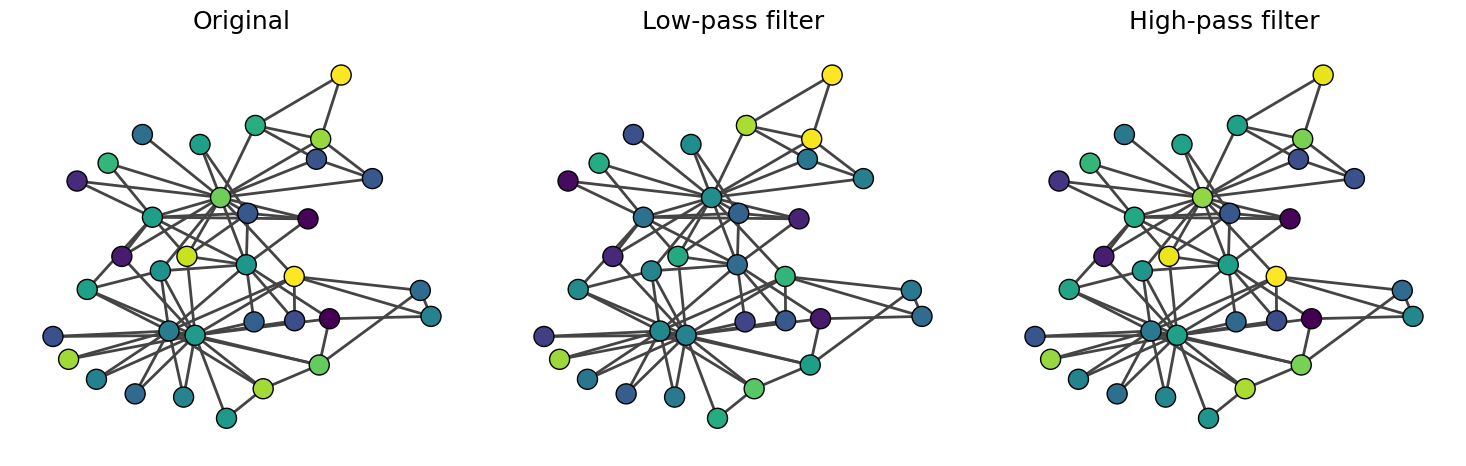

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
palette = sns.color_palette("viridis", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)

# Original
values = x.reshape(-1)
values /= np.linalg.norm(values)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

# Low-pass filter applied
values = L_low @ x
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("Low-pass filter")

# High-pass filter applied
values = L_high @ x
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[2])
axes[2].set_title("High-pass filter")
fig.tight_layout()

We observe that the low-pass filter results in smoother ${\bf x}$ between connected nodes (i.e., neighboring nodes have similar ${\bf x}$).
The original ${\bf x}$ and ${\bf x}'_{\text{low}}$ are very similar because random variables are high-frequency components. In contrast, when we apply the high-pass filter, ${\bf x}'_{\text{high}}$ is similar to ${\bf x}$ because the high-frequency components are not filtered.

Let's now use an eigenvector as our feature vector ${\bf x}$.

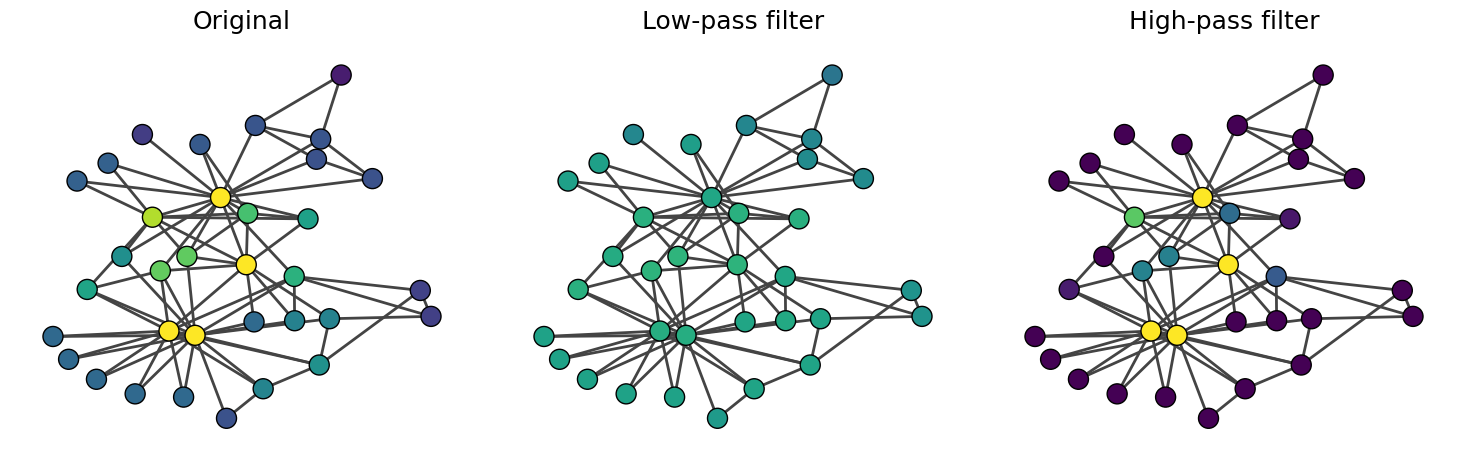

In [7]:
eigen_centrality = np.array(G.eigenvector_centrality()).reshape(-1, 1)
low_pass_eigen = L_low @ eigen_centrality
high_pass_eigen = L_high @ eigen_centrality

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
palette = sns.color_palette("viridis", as_cmap=True)

norm = mpl.colors.Normalize(vmin=-0, vmax=0.3)
values = eigen_centrality.reshape(-1)# high_pass_random.reshape(-1)
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[0])
axes[0].set_title("Original")

values = low_pass_eigen.reshape(-1)
values /= np.linalg.norm(values)
values = values.reshape(-1)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[1])
axes[1].set_title("Low-pass filter")

values = high_pass_eigen.reshape(-1)
values /= np.linalg.norm(values)
ig.plot(G, vertex_color=[palette(norm(x)) for x in values], bbox=(0, 0, 500, 500), vertex_size=20, target=axes[2])
axes[2].set_title("High-pass filter")
fig.tight_layout()

The high-pass filter increases the contrast of the eigenvector centrality, emphasizing the differences between nodes. On the other hand, the low-pass filter smooths out the eigenvector centrality.